In [1]:
from dataset import MetaHDFDataset
import pickle
import torch
import torch.nn as nn
import random
import re
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

traj_batch = 5
n_epochs = 10000
hidden_size = 800
n_layers = 2
learning_rate = 0.001
model_type = 'gru'
print_every = 50
plot_every = 50
bidir = False

from rnn.model import RNN
from rnn.helpers import time_since
metadataset = pickle.load(open('pushing.pickle',"rb"))


In [7]:
### perform perstep prediction 
import h5py
import os
from klampt.model.trajectory import Trajectory
from klampt.io.loader import save
from pdb import set_trace

def plot_pushing_error(model,max_horiz=100):
    test_data = metadataset.MTEST
#     plt.switch_backend("Qt5Agg")
    DATA = h5py.File("pushing.hdf5", "r")

    sse = np.zeros((max_horiz,))
    sse_base = np.zeros((max_horiz,))
    for i, data in enumerate(test_data):
        inp = DATA[data.name + "-IN"]
        out = DATA[data.name + "-OUT"]
        nobj = out.shape[1] // 3
        curr_state = inp
        
        n_datapoints = 0

        for k in range(max_horiz):
            inp_tensor = metadataset.normalize_input(torch.from_numpy(curr_state[:-1,:])
                    .float().to(device)) #timesteps x d
            
            timesteps,d = inp_tensor.shape
            N = int(d/6)
            out_tensor = torch.zeros((timesteps,(N-1)*3)).to(device)
            hidden_layer = rnn.init_hidden(timesteps,device)
            #first feed in the pusher
            output, hidden_layer = model(inp_tensor[:,-6:],hidden_layer)
            #then feed in the object states
            for o_i in range(N-1):
                output, hidden_layer = model(inp_tensor[:,(o_i)*6:(o_i+1)*6],hidden_layer)
                out_tensor[:,(o_i)*3:(o_i+1)*3] = output
            pred_out = metadataset.denormalize_output(out_tensor).cpu().detach().numpy()
#             out_tensor  = composer.forward_with_weights(inp_tensor, weights)
#             pred_out = bg.D.denormalize_output(out_tensor).cpu().detach().numpy()

            next_state = np.zeros((curr_state.shape[0]-1, curr_state.shape[1]))
            next_state[:, -6:] = curr_state[1:, -6:]
            for j in range(nobj):
                next_state[:, 6*j:6*j+2] = (curr_state[:-1, 6*j:6*j+2] 
                        + pred_out[:, 3*j:3*j+2])
                next_state[:, 6*j+2:6*j+4] = pred_out[:, 3*j:3*j+2]
                next_state[:, 6*j+4] = (curr_state[:-1, 6*j+4] + pred_out[:, 3*j+2])
                next_state[:, 6*j+5] = pred_out[:, 3*j+2]
                sse[k] += np.sum((next_state[:, 6*j:6*j+2] - inp[k+1:, 6*j:6*j+2])**2,
                        axis=None)
                sse_base[k] += np.sum((inp[:-(k+1), 6*j:6*j+2] - inp[k+1:, 6*j:6*j+2])**2,
                        axis=None)
                sse[k] += np.sum((next_state[:, 6*j+4] - inp[k+1:, 6*j+4])**2,
                        axis=None)
                sse_base[k] += np.sum((inp[:-(k+1), 6*j+4] - inp[k+1:, 6*j+4])**2,
                        axis=None)
                n_datapoints += 3*next_state.shape[0]
            curr_state = next_state

    rmses = np.sqrt(sse/n_datapoints)
    rmses_base = np.sqrt(sse_base/n_datapoints)
    
    print(list(rmses))
    
    plt.plot(np.linspace(0.01, max_horiz*0.01, max_horiz), rmses)
    plt.plot(np.linspace(0.01, max_horiz*0.01, max_horiz), rmses_base)
    plt.legend(["Ours", "Naive Baseline"])
    plt.xlabel("Prediction Horizon (s)")
    plt.ylabel("RMSE")
    plt.title("Pushing prediction error")
#     plt.show()

def save_predicted_trajs(bg, out_dir):
    test_data = metadataset.MTEST
    DATA = h5py.File("pushing.hdf5", "r")
    for i, data in enumerate(test_data):
        _, _, _, _, _, weights, composer = bg.run_MAML(structure, data, 
                ret_weights=True)
        inp = DATA[data.name + "-IN"]
        out = DATA[data.name + "-OUT"]
        nobj = out.shape[1] // 3
        curr_state = inp
        milestones = np.zeros((299, 2 + 3*nobj))
        for k in range(299):
            milestones[k, :2] = curr_state[0, -6:-4]
            for j in range(nobj):
                milestones[k, 2+3*j:4+3*j] = curr_state[0, 6*j:6*j+2]
                milestones[k, 4+3*j] = curr_state[0, 6*j+4]
            inp_tensor = bg.D.normalize_input(torch.from_numpy(curr_state[:-1,:])
                    .float().cuda())
            out_tensor  = composer.forward_with_weights(inp_tensor, weights)
            pred_out = bg.D.denormalize_output(out_tensor).cpu().detach().numpy()
            next_state = np.zeros((curr_state.shape[0]-1, curr_state.shape[1]))
            next_state[:, -6:] = curr_state[1:, -6:]
            for j in range(nobj):
                next_state[:, 6*j:6*j+2] = (curr_state[:-1, 6*j:6*j+2] 
                        + pred_out[:, 3*j:3*j+2])
                next_state[:, 6*j+2:6*j+4] = pred_out[:, 3*j:3*j+2]
                next_state[:, 6*j+4] = (curr_state[:-1, 6*j+4] + pred_out[:, 3*j+2])
                next_state[:, 6*j+5] = pred_out[:, 3*j+2]
            curr_state = next_state
        traj = Trajectory(times=np.linspace(0.01, 2.99, 299), milestones=milestones)
        save_name = os.path.join(out_dir, "pred_pose_" + data.name +".traj")
        save(traj, 'auto', save_name)


[0.00037963254616351, 0.0006303171803775761, 0.0008848065326731817, 0.0011484269329343807, 0.0014154179720664278, 0.0016838789742863894, 0.0019528595447185508, 0.002221844955135728, 0.0024905530706050877, 0.0027588079952276293, 0.00302648240843445, 0.003293451002821635, 0.00355962263860943, 0.003824943276936343, 0.004089350123174898, 0.0043527818480400314, 0.004615181180306307, 0.004876509659557951, 0.005136751758154942, 0.005395892019980212, 0.0056539157209883235, 0.005910811467536292, 0.006166567519956034, 0.006421164298874853, 0.006674581353669383, 0.00692680432520944, 0.007177814007866289, 0.007427599601761707, 0.0076761450885115224, 0.007923452167705779, 0.008169587622585418, 0.008414473432215235, 0.00865805279713412, 0.008900305488508226, 0.009141220540023247, 0.009380804392973277, 0.009619068399740402, 0.0098560312885333, 0.010091700787183175, 0.01032609602706776, 0.01055921405062731, 0.010791043663992783, 0.011021570575772825, 0.011250764547530165, 0.011478618182857206, 0.01170

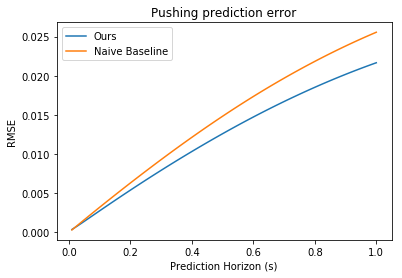

In [8]:
rnn = RNN(input_size = 6, hidden_size = hidden_size, output_size = 3, model_type=model_type, \
          n_layers=n_layers,bidir = bidir).to(device)
rnn.load_state_dict(torch.load('RNN_2.pth'))
plot_pushing_error(model = rnn,max_horiz=100)